In [1]:
import os
import math
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


시드 고정

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
BASE_DIR = "/content/drive/MyDrive/Machine_Learning"

# 손실함수(TimeAwareBCELoss)

In [5]:
class TimeAwareBCELoss(nn.Module):
    def __init__(self, time_penalty_weight=1.0):
        """
        Args:
            time_penalty_weight (float): 시간 흐름에 따른 가중치 강도
                - 0.0 : 시간 가중치 없음 (기존 BCE)
                - 1.0 : 종료 시점 오차가 시작 시점보다 약 2배 더 중요
                - 숫자가 클수록 '후반부 오차'를 더 엄격하게 패널티 줌
        """
        super(TimeAwareBCELoss, self).__init__()
        self.time_penalty_weight = time_penalty_weight

    def forward(self, predictions, targets, inputs):
        """
        Args:
            predictions : (Batch, Seq_Len, 1) - 모델 예측 확률 (Sigmoid 후)
            targets     : (Batch,) or (Batch,1) - 정답 레이블 (0 or 1)
            inputs      : (Batch, Seq_Len, Features) - 원본 입력 데이터 (마스킹용)

        Returns:
            loss        : scalar값
        """

        # 1. 정답(Target) 차원 확장 (B,) or (B,1) -> (B, Seq_Len, 1)
        if targets.dim() == 1:
            targets = targets.view(-1, 1)
        targets_expanded = targets.unsqueeze(1).expand_as(predictions)  # (B, L, 1)

        # 2. 시점별 BCE Loss (reduction='none')
        bce_loss = F.binary_cross_entropy(predictions, targets_expanded, reduction='none')  # (B, L, 1)

        # 3. 시간 가중치
        batch_size, seq_len, _ = predictions.shape
        device = predictions.device

        time_steps = torch.linspace(0, 1, seq_len, device=device).view(1, -1, 1)  # (1, L, 1)
        time_weights = 1.0 + (self.time_penalty_weight * time_steps)              # (1, L, 1)

        weighted_loss = bce_loss * time_weights                                  # (B, L, 1)

        # 4. 패딩 마스크 (입력의 합이 0이면 패딩으로 간주)
        mask = (torch.abs(inputs).sum(dim=-1, keepdim=True) > 0).float()         # (B, L, 1)
        masked_loss = weighted_loss * mask

        # 5. 패딩 제외하고 평균
        loss = masked_loss.sum() / (mask.sum() + 1e-8)
        return loss

# Positional Encoding

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)             # (max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                           # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, S, E)
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

# BasePredictionModel

In [7]:
class BasePredictionModel(nn.Module):
    """
    공통 인터페이스를 위한 추상 모델
    - forward(x): 로짓(logits) 반환
    - predict_proba(x): softmax 확률
    - predict(x): argmax 클래스
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    @torch.no_grad()
    def predict_proba(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, seq_len, num_features)
        return: (B, num_classes)
        """
        self.eval()
        logits = self.forward(x)
        return F.softmax(logits, dim=-1)

    @torch.no_grad()
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, seq_len, num_features)
        return: (B,)  # 예측 클래스 인덱스
        """
        proba = self.predict_proba(x)
        return proba.argmax(dim=-1)

# Transformer

### TransformerModel (BasePredictionModel 상속)

In [8]:
class TransformerModel(BasePredictionModel):
    """
    Encoder-only Time-Series Transformer Model

    입력 x: (B, seq_len, num_features)

    - use_patch = True 인 경우:
        * 시계열을 patch 단위로 잘라 token으로 사용
    - use_patch = False 인 경우:
        * 각 time step이 바로 token (L개의 token)
    """

    def __init__(
        self,
        input_dim: int,          # num_features
        seq_len: int,            # 시계열 길이
        num_classes: int,        # 클래스 개수 (예: 2 = 성공/실패)
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 3,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        use_patch: bool = False,   # TimeAwareLoss 때문에 False
        patch_len: int = 10,
        patch_stride: int = 5,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.seq_len = seq_len
        self.num_classes = num_classes
        self.use_patch = use_patch
        self.patch_len = patch_len
        self.patch_stride = patch_stride

        # ----- Token 차원 설정 -----
        if use_patch:
            token_dim = patch_len * input_dim
            if seq_len < patch_len:
                num_tokens = 1
            else:
                num_tokens = 1 + (seq_len - patch_len) // patch_stride
            self.num_tokens = num_tokens
        else:
            token_dim = input_dim
            self.num_tokens = seq_len

        # 입력 차원 → d_model 로 projection
        self.input_proj = nn.Linear(token_dim, d_model)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model=d_model, max_len=self.num_tokens)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # (B, S, E)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.dropout = nn.Dropout(dropout)

        # 🔵 시퀀스 전체 분류용 head (안 써도 됨, 나중에 쓸 수 있음)
        self.cls_head = nn.Linear(d_model, num_classes)

        # 🔵 TimeAwareBCELoss용: 시점별 실패확률 head
        self.seq_head = nn.Linear(d_model, 1)

    def _create_patches(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, L, C)
        return: (B, num_patches, patch_len * C)
        """
        B, L, C = x.shape

        if L < self.patch_len:
            pad_len = self.patch_len - L
            pad = torch.zeros(B, pad_len, C, device=x.device, dtype=x.dtype)
            x = torch.cat([x, pad], dim=1)
            L = self.patch_len

        patches = x.unfold(dimension=1, size=self.patch_len, step=self.patch_stride)
        patches = patches.contiguous().view(B, -1, self.patch_len * C)
        return patches

    def _prepare_tokens(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, L, C)
        return: (B, S, d_model)
        """
        if self.use_patch:
            tokens = self._create_patches(x)  # (B, S, patch_len * C)
        else:
            tokens = x                        # (B, L, C)
        tokens = self.input_proj(tokens)
        tokens = self.pos_encoder(tokens)
        return tokens

    def forward(self, x: torch.Tensor, return_sequence: bool = False) -> torch.Tensor:
        """
        x: (B, seq_len, num_features)

        return_sequence=False: (B, num_classes)
        return_sequence=True : (B, seq_len, 1)  (use_patch=False 기준)
        """
        tokens = self._prepare_tokens(x)          # (B, S, d_model)
        h = self.transformer_encoder(tokens)      # (B, S, d_model)

        if return_sequence:
            # 🔹 시점별 실패확률 (sigmoid까지)
            logits_seq = self.seq_head(h)         # (B, S, 1)
            probs_seq = torch.sigmoid(logits_seq) # (B, S, 1)
            return probs_seq
        else:
            # 🔹 기존 방식: mean pooling → 클래스 로짓
            h_mean = h.mean(dim=1)                # (B, d_model)
            h_mean = self.dropout(h_mean)
            logits = self.cls_head(h_mean)        # (B, num_classes)
            return logits

# 데이터 로딩

In [9]:
X_train_path = os.path.join(BASE_DIR, "X_train.npy")
y_train_path = os.path.join(BASE_DIR, "y_train.npy")
X_test_path  = os.path.join(BASE_DIR, "X_test.npy")
y_test_path  = os.path.join(BASE_DIR, "y_test.npy")

X_train = np.load(X_train_path)
y_train = np.load(y_train_path)
X_test  = np.load(X_test_path)
y_test  = np.load(y_test_path)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test  shape:", X_test.shape)
print("y_test  shape:", y_test.shape)

X_train shape: (8058, 2400, 9)
y_train shape: (8058,)
X_test  shape: (2033, 2400, 9)
y_test  shape: (2033,)


### 입력 normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

# x_train: (N, L, F)
# x_test : (N, L, F)

scaler = StandardScaler()

# Time-series 전체 feature를 flatten해서 fit해야 함
N, L, C = X_train.shape

X_train_flat = X_train.reshape(-1, C)   # (N*L, C)
X_test_flat  = X_test.reshape(-1, C)    # (N*L, C)

# 스케일러 학습(train만)
scaler.fit(X_train_flat)

# 변환 후 다시 원래 shape으로
x_train = scaler.transform(X_train_flat).reshape(N, L, C)
x_test  = scaler.transform(X_test_flat).reshape(-1, L, C)

In [10]:
# 시계열이 아니라 (N, F)면 L=1로 확장
if X_train.ndim == 2:
    X_train = X_train[:, None, :]
    X_test  = X_test[:, None, :]

X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).long()

In [11]:
BATCH_SIZE = 64

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

seq_len = X_train_tensor.shape[1]
input_dim = X_train_tensor.shape[2]
num_classes = int(y_train_tensor.max().item() + 1)

print(f"seq_len={seq_len}, input_dim={input_dim}, num_classes={num_classes}")

seq_len=2400, input_dim=9, num_classes=2


# 모델 생성 & 학습 준비

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [34]:
model = TransformerModel(
    input_dim=input_dim,
    seq_len=seq_len,
    num_classes=num_classes,
    d_model=64,
    nhead=4,
    num_layers=3,
    dim_feedforward=128,
    dropout=0.1,
    use_patch=False,
    patch_len=10,
    patch_stride=5,
).to(device)

In [40]:
criterion = TimeAwareBCELoss(time_penalty_weight=0.4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 20

In [41]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)              # (B, L, F)
        yb = yb.to(device)              # (B,)

        # 시점별 실패 확률 (B, S, 1)
        preds_seq = model(xb, return_sequence=True)

        # BCE target은 float이어야 함
        yb_float = yb.float()           # (B,)

        loss = criterion(preds_seq, yb_float, xb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    # ==============================
    #  테스트 성능 + 최적 threshold 탐색
    # ==============================
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds_seq = model(xb, return_sequence=True)   # (B, S, 1)
            # TimeAware: 마지막 시점 실패 확률 사용
            p_fail_last = preds_seq[:, -1, 0]             # (B,)

            all_probs.append(p_fail_last.cpu())
            all_labels.append(yb.cpu())

    all_probs = torch.cat(all_probs)       # (N,)
    all_labels = torch.cat(all_labels)     # (N,)

    probs_np = all_probs.numpy()
    labels_np = all_labels.numpy()

    # ---------------------------------
    # ★ 최적 threshold 탐색 (F1_클래스1 최대)
    # ---------------------------------
    best_thr = 0.5
    best_f1 = -1.0

    # 예: 0.1 ~ 0.9 사이를 0.01 간격으로 스캔
    for thr in np.linspace(0.1, 0.9, 81):
        preds_thr = (probs_np >= thr).astype(int)
        f1 = f1_score(labels_np, preds_thr, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    # 최적 threshold 기준으로 최종 예측/성능 계산
    final_preds = (probs_np >= best_thr).astype(int)
    acc = accuracy_score(labels_np, final_preds)

    print(
        f"[Epoch {epoch:02d}] "
        f"train_loss={avg_loss:.4f} | "
        f"best_thr={best_thr:.3f} | "
        f"F1_1={best_f1:.4f} | "
        f"test_acc={acc*100:.2f}%"
    )

[Epoch 01] train_loss=0.5874 | best_thr=0.250 | F1_1=0.5870 | test_acc=63.80%
[Epoch 02] train_loss=0.5822 | best_thr=0.300 | F1_1=0.5908 | test_acc=65.32%
[Epoch 03] train_loss=0.5823 | best_thr=0.190 | F1_1=0.5899 | test_acc=63.75%
[Epoch 04] train_loss=0.5804 | best_thr=0.330 | F1_1=0.5929 | test_acc=66.16%
[Epoch 05] train_loss=0.5756 | best_thr=0.320 | F1_1=0.5913 | test_acc=68.86%
[Epoch 06] train_loss=0.5746 | best_thr=0.220 | F1_1=0.5893 | test_acc=63.11%
[Epoch 07] train_loss=0.5745 | best_thr=0.260 | F1_1=0.5881 | test_acc=64.24%
[Epoch 08] train_loss=0.5726 | best_thr=0.250 | F1_1=0.5909 | test_acc=64.78%
[Epoch 09] train_loss=0.5714 | best_thr=0.270 | F1_1=0.5896 | test_acc=64.39%
[Epoch 10] train_loss=0.5738 | best_thr=0.260 | F1_1=0.5917 | test_acc=64.29%
[Epoch 11] train_loss=0.5739 | best_thr=0.330 | F1_1=0.5890 | test_acc=66.16%
[Epoch 12] train_loss=0.5738 | best_thr=0.260 | F1_1=0.5954 | test_acc=65.57%
[Epoch 13] train_loss=0.5687 | best_thr=0.300 | F1_1=0.5880 | te

# 모델 저장

★ 성공 -> 0

★ 실패 -> 1

In [66]:
import os
import torch
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix
)

In [67]:
BASE_DIR = "/content/drive/MyDrive/Machine_Learning"
RESULT_DIR = os.path.join(BASE_DIR, "result")
os.makedirs(RESULT_DIR, exist_ok=True)

print("RESULT_DIR:", RESULT_DIR)

RESULT_DIR: /content/drive/MyDrive/Machine_Learning/result


###.pt 저장

In [68]:
save_model_path = os.path.join(RESULT_DIR, "transformer_model.pt")
torch.save(model.state_dict(), save_model_path)
print(">> 모델 저장 완료:", save_model_path)

>> 모델 저장 완료: /content/drive/MyDrive/Machine_Learning/result/transformer_model.pt


### 예측값/확률 저장

In [69]:
model.eval()
all_p_fail = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        # TimeAware 용 시퀀스 출력: (B, L, 1)
        preds_seq = model(xb, return_sequence=True)
        # 마지막 시점 실패 확률: (B,)
        p_fail_last = preds_seq[:, -1, 0].cpu()

        all_p_fail.append(p_fail_last)
        all_labels.append(yb.cpu())

all_p_fail = torch.cat(all_p_fail).numpy()   # (N,)
all_labels = torch.cat(all_labels).numpy()   # (N,)

print(">> 테스트 샘플 수:", len(all_labels))

>> 테스트 샘플 수: 2033


In [70]:
best_thr = 0.5
best_f1 = -1.0

for thr in np.linspace(0.1, 0.9, 81):
    preds = (all_p_fail >= thr).astype(int)
    f1 = f1_score(all_labels, preds, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print(">> 최적 threshold:", best_thr)
print("   해당 F1_1:", best_f1)

>> 최적 threshold: 0.58
   해당 F1_1: 0.8922585794094174


In [71]:
y_pred = (all_p_fail >= best_thr).astype(int)

df_out = pd.DataFrame({
    "y_true": all_labels,
    "y_pred": y_pred,
    "p_fail": all_p_fail,
})

csv_path = os.path.join(RESULT_DIR, "transformer_test_predictions.csv")
df_out.to_csv(csv_path, index=False)
print(">> 테스트 예측 결과 CSV 저장:", csv_path)

>> 테스트 예측 결과 CSV 저장: /content/drive/MyDrive/Machine_Learning/result/transformer_test_predictions.csv


In [75]:
df = pd.read_csv(csv_path)

print("=== CSV 내용 ===")
print(df.head())

print("\n=== 데이터 개수 ===")
print(df.shape)

=== CSV 내용 ===
   y_true  y_pred    p_fail
0       0       0  0.011169
1       1       0  0.228618
2       1       0  0.293438
3       0       0  0.021581
4       0       0  0.280572

=== 데이터 개수 ===
(2033, 3)


### score .yaml 저장

In [73]:
acc = accuracy_score(df_out["y_true"], df_out["y_pred"])
cls_report = classification_report(df_out["y_true"], df_out["y_pred"], digits=4)
cm = confusion_matrix(df_out["y_true"], df_out["y_pred"])

print("\n=== Accuracy ===")
print(acc)

print("\n=== Precision / Recall / F1 ===")
print(cls_report)

print("\n=== Confusion Matrix ===")
print(cm)


=== Accuracy ===
0.9335956714215445

=== Precision / Recall / F1 ===
              precision    recall  f1-score   support

           0     0.9370    0.9675    0.9520      1384
           1     0.9255    0.8613    0.8923       649

    accuracy                         0.9336      2033
   macro avg     0.9313    0.9144    0.9221      2033
weighted avg     0.9333    0.9336    0.9329      2033


=== Confusion Matrix ===
[[1339   45]
 [  90  559]]


In [74]:
metrics = {
    "best_threshold": float(best_thr),
    "best_f1_class1": float(best_f1),
    "accuracy": float(acc),
    "confusion_matrix": cm.tolist(),  # YAML 저장 위해 list로 변환
    "num_test_samples": int(len(all_labels)),
}

yaml_path = os.path.join(RESULT_DIR, "metrics.yaml")
with open(yaml_path, "w") as f:
    yaml.dump(metrics, f)

print(">> Metrics YAML 저장 완료:", yaml_path)

>> Metrics YAML 저장 완료: /content/drive/MyDrive/Machine_Learning/result/metrics.yaml


# 성능 확인

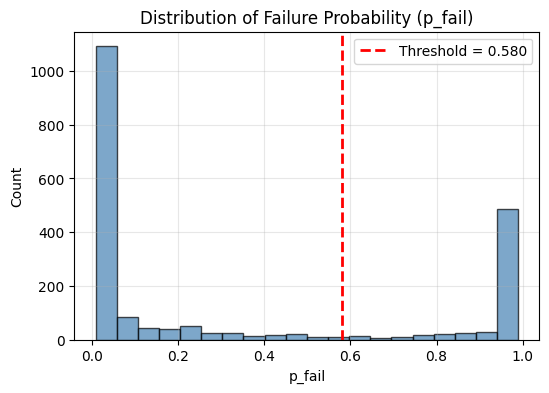

>> 히스토그램 저장: /content/drive/MyDrive/Machine_Learning/result/p_fail_hist.png


In [76]:
# (1) 실패 확률 분포 히스토그램 + threshold 라인
plt.figure(figsize=(6,4))
plt.hist(df_out["p_fail"], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(best_thr, color='red', linestyle='--', linewidth=2, label=f"Threshold = {best_thr:.3f}")
plt.title("Distribution of Failure Probability (p_fail)")
plt.xlabel("p_fail")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
hist_path = os.path.join(RESULT_DIR, "p_fail_hist.png")
plt.savefig(hist_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()
print(">> 히스토그램 저장:", hist_path)

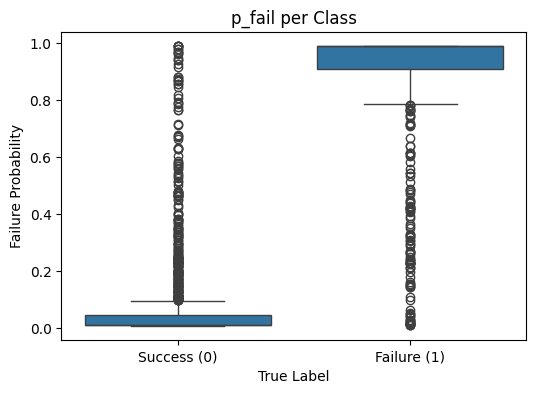

>> 박스플롯 저장: /content/drive/MyDrive/Machine_Learning/result/p_fail_boxplot.png


In [77]:
# (2) 클래스별 p_fail 박스플롯
plt.figure(figsize=(6,4))
sns.boxplot(x=df_out["y_true"], y=df_out["p_fail"])
plt.xticks([0, 1], ["Success (0)", "Failure (1)"])
plt.title("p_fail per Class")
plt.xlabel("True Label")
plt.ylabel("Failure Probability")
box_path = os.path.join(RESULT_DIR, "p_fail_boxplot.png")
plt.savefig(box_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()
print(">> 박스플롯 저장:", box_path)

/tmp/ipython-input-2218902520.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_out["p_fail"][df_out["y_true"] == 0], label="Success (0)", shade=True)
/tmp/ipython-input-2218902520.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_out["p_fail"][df_out["y_true"] == 1], label="Failure (1)", shade=True)


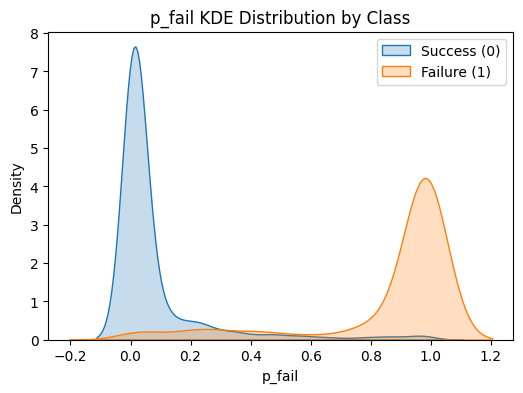

>> KDE 플롯 저장: /content/drive/MyDrive/Machine_Learning/result/p_fail_kde.png


In [78]:
# (3) KDE 플롯 (클래스별 p_fail 분포)
plt.figure(figsize=(6,4))
sns.kdeplot(df_out["p_fail"][df_out["y_true"] == 0], label="Success (0)", shade=True)
sns.kdeplot(df_out["p_fail"][df_out["y_true"] == 1], label="Failure (1)", shade=True)
plt.title("p_fail KDE Distribution by Class")
plt.xlabel("p_fail")
plt.legend()
kde_path = os.path.join(RESULT_DIR, "p_fail_kde.png")
plt.savefig(kde_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()
print(">> KDE 플롯 저장:", kde_path)

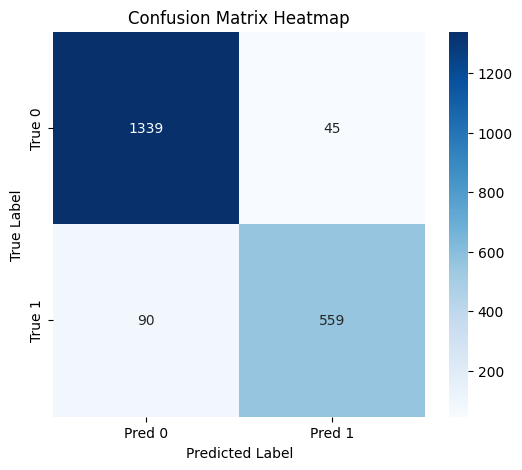

>> Heatmap 저장 완료: /content/drive/MyDrive/Machine_Learning/result/confusion_matrix_heatmap.png


In [80]:
# (4) Heatmap
# Confusion matrix 계산
cm = confusion_matrix(df_out["y_true"], df_out["y_pred"])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)

plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 저장 경로
heatmap_path = os.path.join(RESULT_DIR, "confusion_matrix_heatmap.png")
plt.savefig(heatmap_path, dpi=300, bbox_inches="tight")

plt.show()

print(">> Heatmap 저장 완료:", heatmap_path)